## Telco Churn Prediction

### Business Understanding

**Problem Statement:**  With the increasing rate of customer attrition in the telco industry, we would like to build a machine learning model to ascertain what factors cause customer attrition and what will also make them stick with a particular telco firm.

**Goal:** To build a machine learning model to find the likelihood of a customer leaving the organisation, the key indicators of churn as well as the retention strategies that can be implemented to avert this problem.

**Null Hypothesis:** There is no relationship between internet service and customer attrition

**Alternate Hypothesis:** There is a relationship between internet service and customer attrition

### Analytical Questions 
1. Do TV streaming customers have a higher monthly charge?
2. What is the effect of online security and protection on customer retention?
3. What is the relationship between customer age and the type of contract used?
4. Do customers with dependents have more internet security?
5. How does the quality of phone service impact the overall customer satisfaction
6. What aspects of tech support determines a customers decision to remain loyal to a company

### Importation of Libraries

In [43]:
import sqlalchemy as sa 
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import numpy as np 
from scipy import stats
from scipy.stats import kruskal
import plotly.graph_objects as go
import seaborn as sns
import collections
import warnings

###FILTER WARNINGS

from sklearn.model_selection import * #train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.metrics import *
from sklearn.model_selection import * 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression




ModuleNotFoundError: No module named 'sklearn'

### Extracting and Loading Data

In [3]:
# Load environment variables from .env file
environment_variables = dotenv_values('.env')

# Get the values for the credentials set in the '.env' file
server = os.getenv("SERVER")
database = os.getenv("DATABASE")
username = os.getenv("USERNAME")
password = os.getenv("PASSWORD")

In [4]:
# connect to the database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [5]:
query = "SELECT * FROM LP2_Telco_churn_first_3000"
 
df1 = pd.read_sql(query, connection)

C:\Users\PC\AppData\Local\Temp\ipykernel_18716\3541714103.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query, connection)


In [6]:
df1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
df1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [9]:
df1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,3000,3000,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,3000,2,Male,1537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,3000,2,False,2525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,3000,2,False,1538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,3000,2,False,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,3000.0,NaN,NaN,NaN,32.527333,24.637768,0.0,9.0,29.0,56.0,72.0
PhoneService,3000,2,True,2731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2731,2,False,1437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,3000,3,Fiber optic,1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2349,2,False,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df1.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [11]:
duplicate = df1[df1.duplicated()]
duplicate.shape

(0, 21)

array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

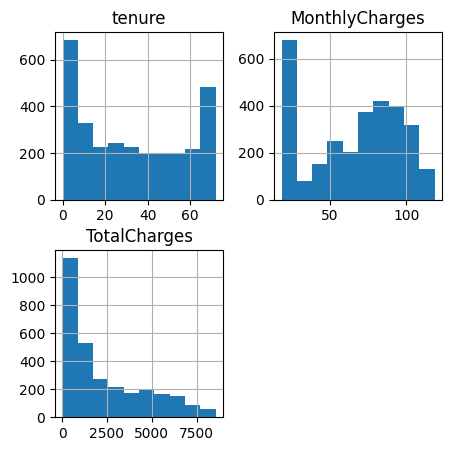

In [12]:
df1.hist(figsize=(5, 5))

In [13]:
df2 = pd.read_csv('../Data/LP2_Telco-churn-second-2000.csv')
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [15]:
df2.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2043,2043,5600-PDUJF,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2043,2,Male,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2043.0,NaN,NaN,NaN,0.16838,0.374295,0.0,0.0,0.0,0.0,1.0
Partner,2043,2,No,1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2043,2,No,1412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2043.0,NaN,NaN,NaN,32.649046,24.376248,0.0,9.0,30.0,55.0,72.0
PhoneService,2043,2,Yes,1823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2043,3,No,987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2043,3,Fiber optic,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2043,3,No,1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df2.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
duplicate = df2[df2.duplicated()]
duplicate.shape

(0, 21)

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>, <Axes: >]],
      dtype=object)

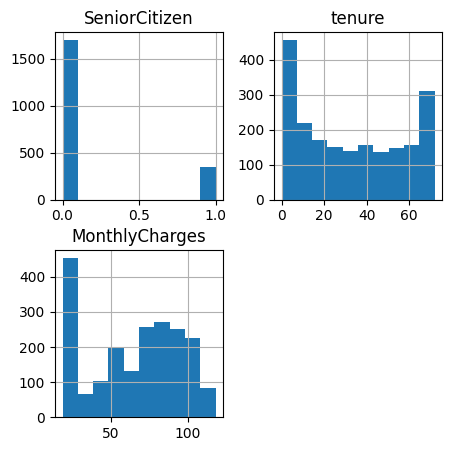

In [18]:
df2.hist(figsize=(5, 5))

In [19]:
pd.set_option('display.max_rows', None)
final_df = pd.concat([df1,df2],axis=0,ignore_index=True)
final_df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


### Univariate Analysis

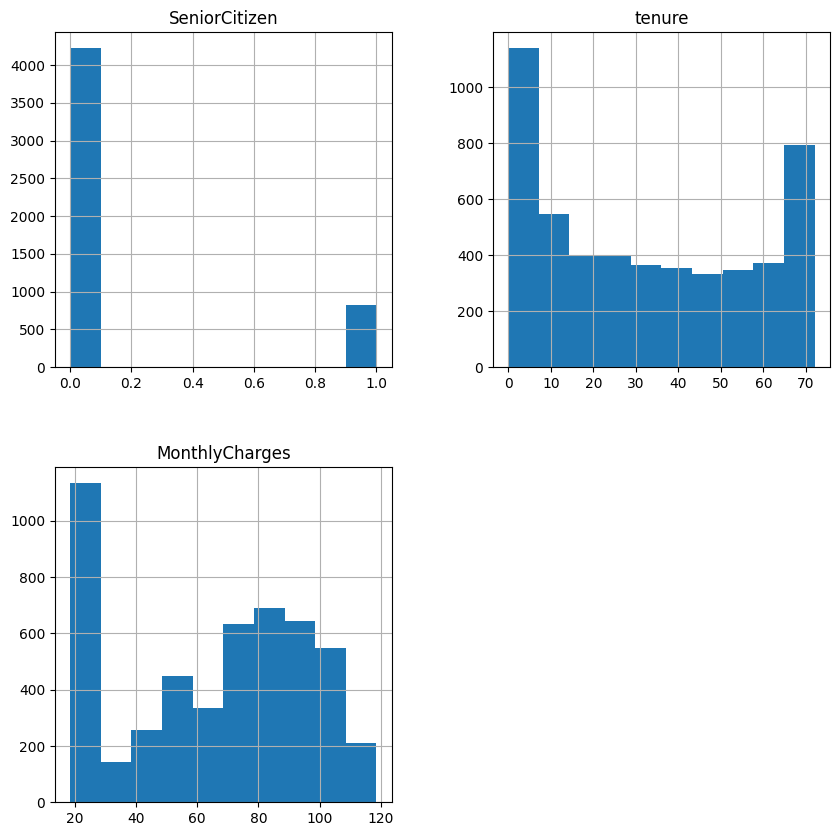

In [20]:
final_df.hist(figsize=(10, 10))
plt.show()

In [21]:
# Convert 'TotalCharges' to float and handle non-convertible values with NaN
final_df['TotalCharges'] = pd.to_numeric(final_df['TotalCharges'], errors='coerce')

In [22]:
# Verify the data type after conversion
final_df['TotalCharges'].dtype

dtype('float64')

### Replacing all negatives with False and positives with True

In [32]:
final_df.replace(['No','No internet service','false','No phone service'], "False", inplace=True)

final_df.replace('Yes',"True", inplace=True)

In [33]:
final_df['SeniorCitizen'] = np.where(final_df['SeniorCitizen'] == 1, True, False)

In [34]:
final_df.InternetService.replace('false','None')

0               DSL
1               DSL
2               DSL
3               DSL
4       Fiber optic
5       Fiber optic
6       Fiber optic
7               DSL
8       Fiber optic
9               DSL
10              DSL
11            False
12      Fiber optic
13      Fiber optic
14      Fiber optic
15      Fiber optic
16            False
17      Fiber optic
18              DSL
19      Fiber optic
20              DSL
21            False
22            False
23              DSL
24              DSL
25              DSL
26      Fiber optic
27              DSL
28              DSL
29              DSL
30      Fiber optic
31      Fiber optic
32              DSL
33            False
34              DSL
35      Fiber optic
36      Fiber optic
37      Fiber optic
38      Fiber optic
39      Fiber optic
40              DSL
41              DSL
42            False
43              DSL
44              DSL
45      Fiber optic
46              DSL
47      Fiber optic
48              DSL
49              DSL


### Making the True/False to Boolean

In [35]:
final_df.replace({'True': True, 'False': False}, inplace=True)

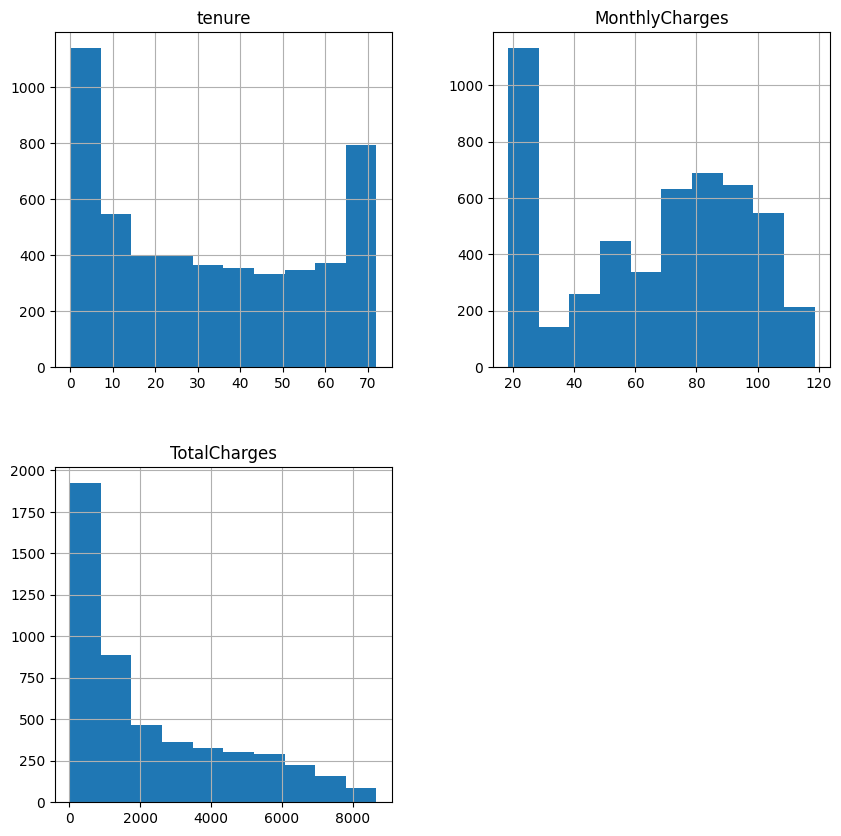

In [36]:
final_df.hist(figsize=(10, 10))
plt.show()

In [40]:
# Visualize the distribution of categorical columns
categoricals = [column for column in final_df.columns if final_df[column].dtype == "O"]
for column in categoricals:
        if column not in ['customerID']:
                fig = px.histogram(final_df, x=final_df[column], text_auto=True,color=column,
                               title=f"Distribution of customers based on {column}")
                fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-45)
                fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### OBSERVATION
- The Gender is evenly distributed 
- Over 50% of all contract types are month-on-month basis
- Electronic Check is the most used,covering 30% of all payment methods

In [ ]:
fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.boxplot(com_df.tenure)
plt.show()

In [ ]:
fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.boxplot(com_df.MonthlyCharges)
plt.show()

### Bivariate Analysis

In [ ]:
# Summarizing the relationships between the variables with a heatmap of the correlations
correlation_matrix = com_df.corr(numeric_only= True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag')
plt.title("Correlation heatmap of the Telecom Dataset")
plt.show()

 ## `Answering the Analytical Questions`

##### `How does tenure and monthly charge affect customer churn?`

In [ ]:
bins = [ 10, 30, 50,70]
df=com_df
labels = ['Newbie', 'Young', 'Oldies']
df['tenure Group'] = pd.cut(df['tenure'], bins=bins, labels=labels)
streamers = com_df.groupby(['tenure Group','Churn'])['MonthlyCharges'].mean().sort_values(ascending=True)
#sns.displot(streamers, x="tenure Group",hue="Churn", element="step")
streamers.plot(kind='bar', title = 'How does tenure and monthly charge affect customer churn', figsize = (10,6), cmap='Dark2', rot = 30);
#streamers.plot(kind='bar')
plt.show()

#### OBSERVATION
- New,Existing and Old Customers with higher charges for software usage are the ones churning.
- There has to be a loyalty promotion for old customers to lock in the old customers.
- There can also be a signup discount to new customers to lock them in on the software.

##### `What is the likelihood of a customer with online security and device protection to churn?`

In [ ]:
cust_retention = com_df.groupby(['OnlineSecurity','DeviceProtection'])['Churn'].count().sort_values(ascending=True)
cust_retention.plot(kind='bar', title = 'The likelihood of a customer with online security and device protection to churn', figsize = (10,6), cmap='Dark2', rot = 30)

#### OBSERVATION
- Customers with no security at all are more likely to Churn. 
- Basic cybersecurity can be done to curb customer doubt to reduce Churn.

#### `What is the relationship between the type of contract and the likelihood of a customer churn?`

In [ ]:
cust_contract = com_df.groupby('Contract')['Churn'].count().sort_values(ascending=True)
cust_contract.plot(kind='bar', title = 'The relationship between the type of contract and the likelihood of a customer churn', figsize = (10,6), cmap='Dark2', rot = 30)

#### OBSERVATION
- Month-to-Month Customers are more likely to churn as they are likely to be floating users.

#### `Do customers with dependents and internet security likely to Churn?`

In [ ]:
cust_contract = com_df.groupby(['OnlineSecurity','Dependents'])['Churn'].count().sort_values(ascending=True)
cust_contract.plot(kind='bar', title = 'Do customers with dependents and internet security likely to Churn?', figsize = (10,6), cmap='Dark2', rot = 30)

#### OBSERVATION
Customers with both Online Security and Dependents are less likely to churn.

In [ ]:
com_df.isnull().sum()

In [ ]:
#Dropping Empty rows
com_df = com_df.dropna(subset=['OnlineSecurity','OnlineBackup','DeviceProtection','MultipleLines','TotalCharges','Churn'],axis=0)

In [ ]:
#finding duplicates
duplicate = com_df[com_df.duplicated()]
duplicate.shape

##### OBSERVATION 
No duplicates found

### `HYPOTHESIS`

In [ ]:
#Checking Normality of the data 

def check_normality(data,name):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.20f" % p_value_normality)
    if p_value_normality <0.05:
        print(f"Reject null hypothesis >> The data for {name} is not normally distributed")
    else:
        print(f"Fail to reject null hypothesis >> The data for {name} is normally distributed")

In [ ]:
#Hypothesis

df_tech= com_df.loc[com_df.OnlineSecurity & com_df.DeviceProtection]
online=com_df.loc[com_df.OnlineSecurity]
device= com_df.loc[com_df.DeviceProtection]

In [ ]:
#Normality Checks
check_normality(df_tech.TotalCharges,'Online Security and Device Protection')
check_normality(online.TotalCharges,'Online Security')
check_normality(device.TotalCharges,'Device Protection')

In [ ]:
#Using the P-Levene to test the Hypothesis
stat, pvalue_levene= stats.levene(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges )

print("p value:%.10f" % pvalue_levene)
if pvalue_levene <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

##### Observation 
- Data samples are not normally distributed
- The variances of the samples are different
- Therefore a Non-Parametric test must be done (Kruskal Test)

In [ ]:
#Kruskal Test

stat, p = kruskal(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges)
print('Statistics=%.3f, p=%.15f' % (stat, p))

if p > 0.05:
 print('All sample distributions are the same (fail to reject H0)')
else:
 print('One or more sample distributions are not equal distributions (reject null Hypothesis)')

##### OBSERVATION
Reject the null Hypothesis

### `Data preparation`

#### Feature Correlation and Selection

In [ ]:
# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = df.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the dataset")
plt.show()

In [ ]:
df =com_df.drop(columns=['customerID','gender','TotalCharges','tenure Group'],axis=1)
df.head(1)

In [ ]:
# Dropping row with null value
df.dropna(axis=0, inplace=True)

In [ ]:
df.replace({True: 'Yes', False: 'No'})
df.head(1)

In [ ]:
def str_convert(df,column_name):
    df[column_name]=df[column_name].replace({True: 'True', False: 'False'})

    return df

In [ ]:
df=str_convert(df,"PaperlessBilling")
df=str_convert(df,"PhoneService")
df=str_convert(df,"SeniorCitizen")
df=str_convert(df,"Partner")
df=str_convert(df,"InternetService")
df=str_convert(df,"Dependents")

In [ ]:
df["Churn"].unique().tolist()
df["Churn"]=df["Churn"].replace({True: '1', False: '0'})

#### `Distribution of the dependent variable`

##### STRATIFICATION ZONE

In [ ]:
# Separate majority and minority classes
df_stay = df[df.Churn=='0']
df_left = df[df.Churn=='1']

print((len(df_stay)/len(df)),(len(df_left)/len(df)))
print(len(df_left))

##### Observation
- About 70% of the customers stayed as compared to the customers that left therefore the churned customers represent the minority group

In [ ]:
# Downsample minority class
df_minority_upsampled = resample(df_left, 
                                 replace=True,     # sample with replacement
                                 n_samples=2886,    # to match majority class
                                 random_state=27) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_stay, df_minority_upsampled])

In [ ]:
#Checking sample
df_upsampled.Churn.value_counts()

In [ ]:
df.dtypes

df["InternetService"].replace("False", "No", inplace=True)
df["InternetService"].astype(str)
df["InternetService"].unique().tolist()

In [ ]:
df.head(3)

In [ ]:
# Looking at the descriptive statistics of the columns with categorical values
cats = [column for column in df.columns if (df[column].dtype == "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
df[cats].describe(include="all")

In [ ]:
# Looking at the descriptive statistics of the columns with numeric values
numerics = [column for column in df.columns if (df[column].dtype != "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
df[numerics].describe()

In [ ]:
# Create a boolean mask to identify boolean columns
boolean_mask = df.dtypes == bool

# Select columns with boolean values
boolean_columns = df.columns[boolean_mask]

# Display the selected columns
boolean_columns

#### `Modeling`

In [ ]:
cats=df.select_dtypes('object').columns

In [ ]:
numerics = df.select_dtypes('number').columns

In [ ]:
numerics

In [ ]:
cats

In [ ]:
df.dtypes

In [ ]:
cols= df.columns.tolist()
for col in cols:
        unique=df[col].unique().tolist()
        print(col,unique)

In [ ]:
X=df.drop(columns=['Churn'],axis=1)
y=df['Churn']

In [ ]:
for column in X.select_dtypes('object'):
    print(column)

In [ ]:
X.columns

In [ ]:
X.dtypes

def str_(df):
    cols= df.columns.tolist()

    for col in cols:
        unique=df[col].unique().tolist()
        if len(unique)==2:
            df[col]= df[col].astype(str)
            print(col,unique)
    return df

X=str_(X)

In [ ]:
cats=X.select_dtypes('object').columns

In [ ]:
cats

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=27)

In [ ]:
y_test

In [ ]:
# making pipeline
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# putting numeric columns to scaler and categorical to encoder
num_transformer = Pipeline(steps=[
    ('num', scaler)
])
cat_transformer = Pipeline(steps=[
    ('cat', encoder)
])

In [ ]:
# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer , numerics),
                    ('cat', cat_transformer , cats)])

In [ ]:
#### Call models
#logres
#xgboost
#Catboost
#SVM
from sklearn.svm import SVC 

In [ ]:
svc_mod= Pipeline(steps=[("preprocessor", preprocessor), 
                          ("model",SVC(kernel='linear') )])
 
# fitting x samples and y classes 
svc_mod.fit(X_train, y_train) 

In [ ]:
# Predict on the test data
svc_mod_pred = svc_mod.predict(X_test)
svc_mod_pred

In [ ]:
# Evaluate the model
svc_mod_report = classification_report(y_test, svc_mod_pred)
print(svc_mod_report)

In [ ]:
# Confusion Matrix
svc_mod_conf_mat = confusion_matrix(y_test, svc_mod_pred)
svc_mod_conf_mat

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(svc_mod_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.show()

In [ ]:
## CatBoost Classifier
CatBoost_mod = Pipeline(steps=[("preprocessor", preprocessor), 
                          ("model", CatBoostClassifier(random_state=27, verbose = False))])


CatBoost_mod.fit(X_train, y_train)

In [ ]:
# Predict on the test data
CatBoost_mod_pred = CatBoost_mod.predict(X_test)
CatBoost_mod_pred

In [ ]:
# Evaluate the model
CatBoost_mod_report = classification_report(y_test, CatBoost_mod_pred)
print(CatBoost_mod_report)

In [ ]:
# Confusion Matrix
CatBoost_mod_conf_mat = confusion_matrix(y_test, CatBoost_mod_pred)
CatBoost_mod_conf_mat

In [ ]:
# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(CatBoost_mod_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.show()